# Team 4 - Brian Ellis & Luke Kerwin
## GP1 - DS310

### Our Best Model:
No scaling, random state 23 split 80/20<br>
Col 1, 3, 4, 5, 6, 7, 8, 9, 10 features<br>
Lasso alpha 0.1, RF, and XGB Voting Regressor

It's vital that our features remain independent to prevent multicollinearity which would hurt our regression model. Our first step is to examine, and most importantly, visualize the data and the relationships between features so that we can identify any multicollinearity.

Correlation between our variables is not helpful when building a regression model. Let's identify the most highly correlated variables.

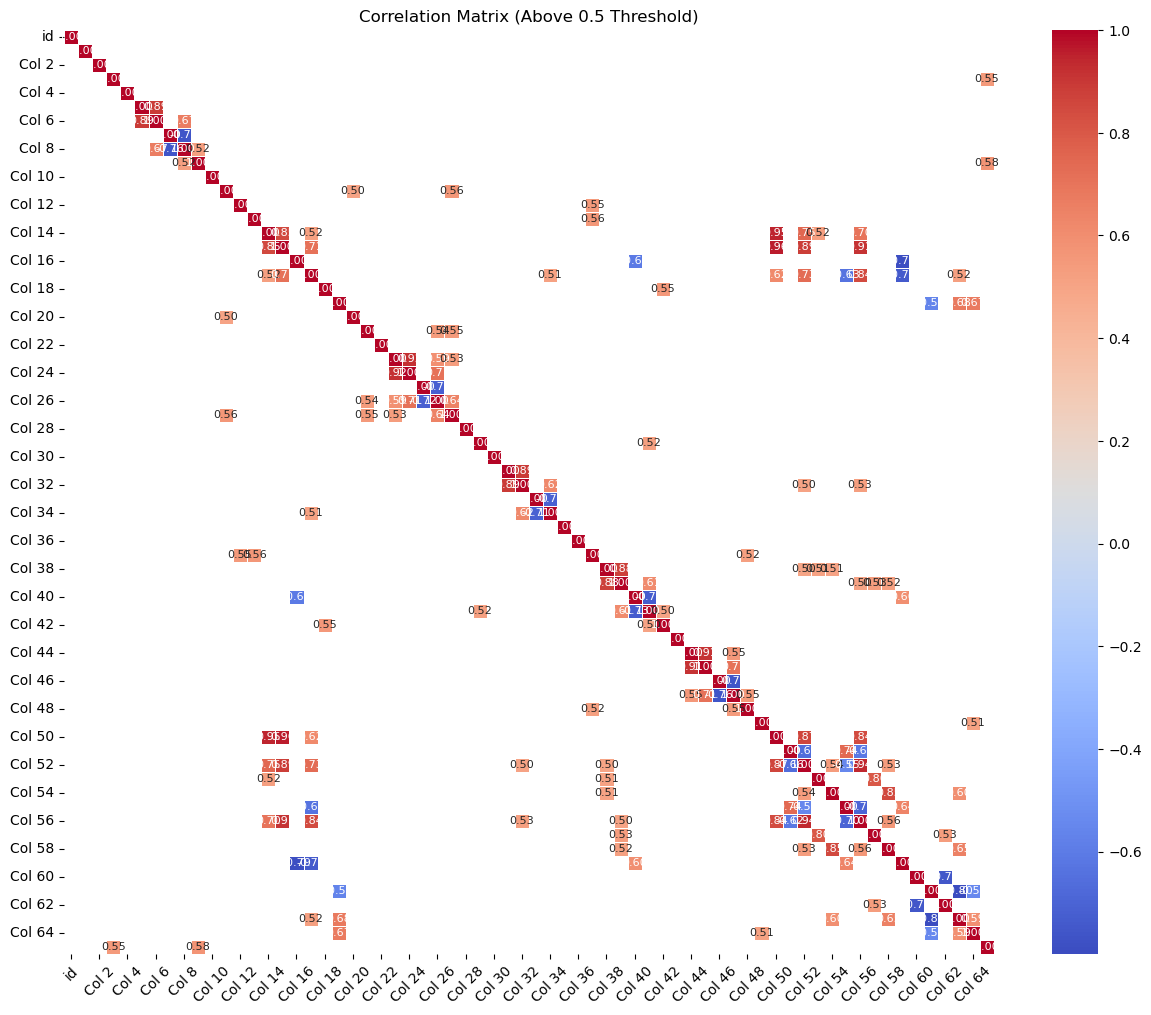

In [53]:
correlation_matrix = df.corr()
# Set the threshold for correlation
threshold = 0.5

# Filter the correlation matrix to keep values above the threshold
high_corr_matrix = correlation_matrix[abs(correlation_matrix) > threshold]

# Increase figure size and adjust font size
plt.figure(figsize=(15, 12))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})

# Rotate variable names for better readability
plt.xticks(rotation=45)

plt.title(f'Correlation Matrix (Above {threshold} Threshold)')
plt.show()

It looks like there are no null values and it seems as if the data is already scaled. These numbers are small though which might cause problems with gradient descent so we will still implement a scaler.

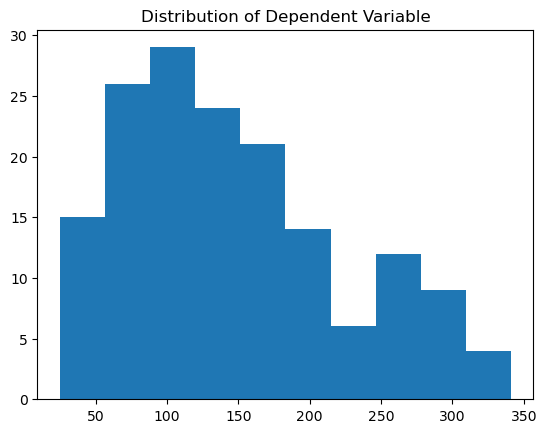

In [54]:
plt.hist(df['y'])
plt.title("Distribution of Dependent Variable")
plt.show()

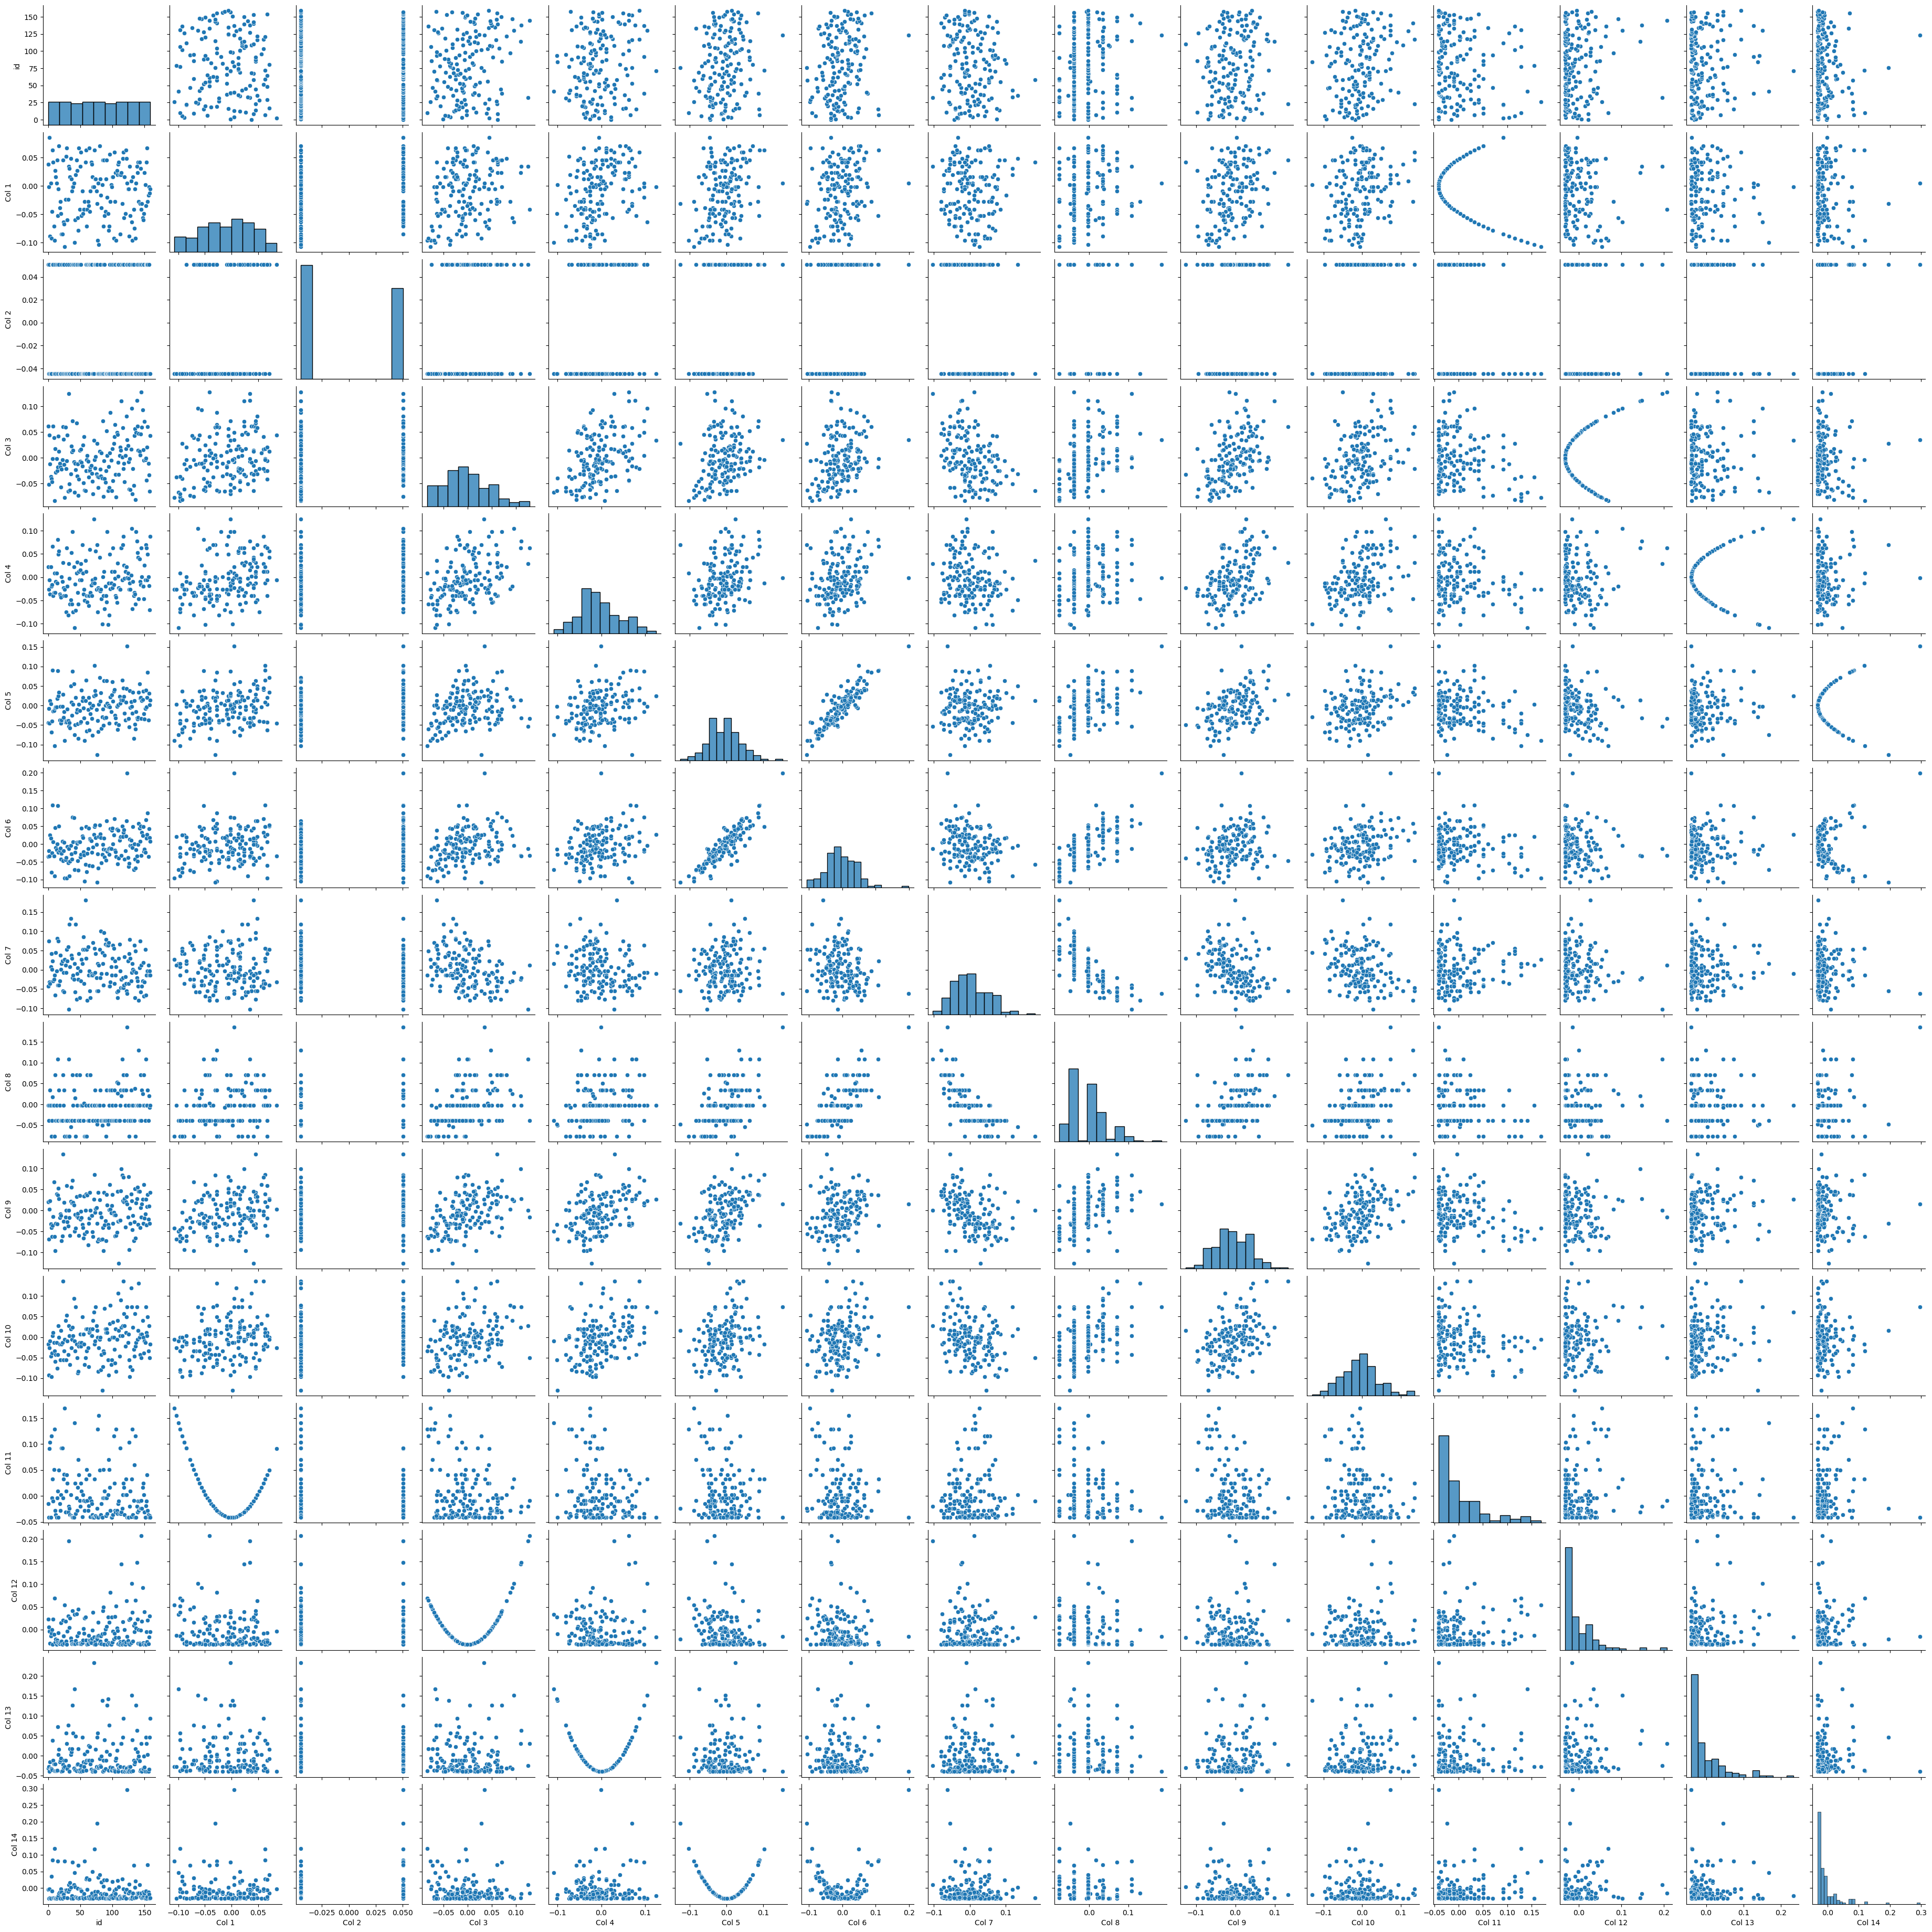

In [55]:
import seaborn as sns
sns.pairplot(df.iloc[:, :15])

There are several interesting relationships between our selected features. `Col 6` and `Col 32` seem to be perpendicular to eachother as well as `Col 7` and `Col 33`.<br>We also see a quadratic relationship between `Col 3` and `Col 12` as well as `Col 4` and `Col 13`.<br>The interval between these features should be noted as well: `Col 3` and `Col 29` have a difference of 26 features which is the same difference as `Col 9` and ` Col 35`. The quadratic pairs are 9 features a part.<br>These relationships can be troublesome for our regression models because they are not indpendent features and are correlated with other features.

We attempt to verify that these added features are simply transformations on previous variables.

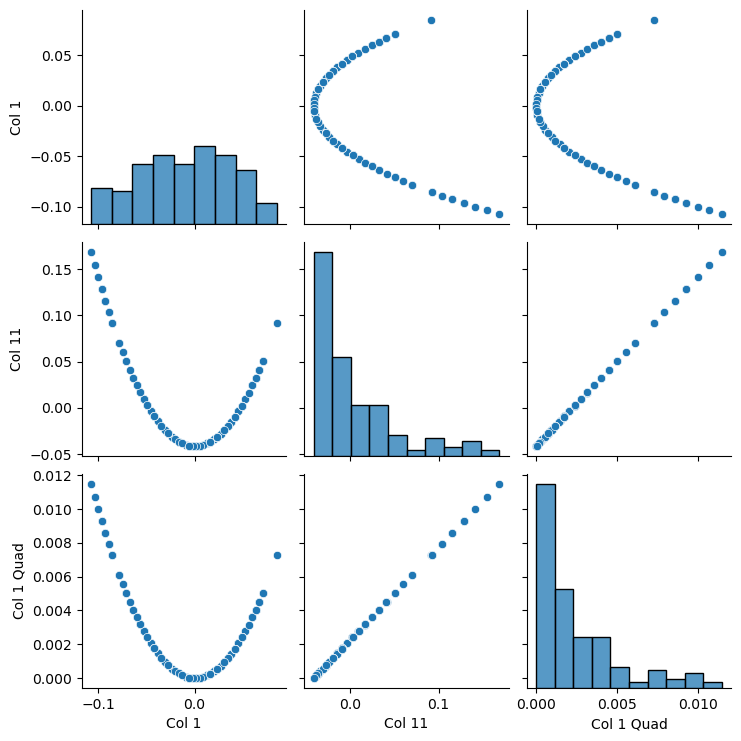

In [58]:
sns.pairplot(df[['Col 1', 'Col 11', 'Col 1 Quad']])

We receieve the same result with our `Col 1 Quad` variable as `Col 11`. `Col 11` as well as the columns after it, are simply the first few columns squared, (besides `Col 2`).

Since this quadratic relationship begins at `Col 11`, we should remove all columns starting there. But let's visualize further to make sure.

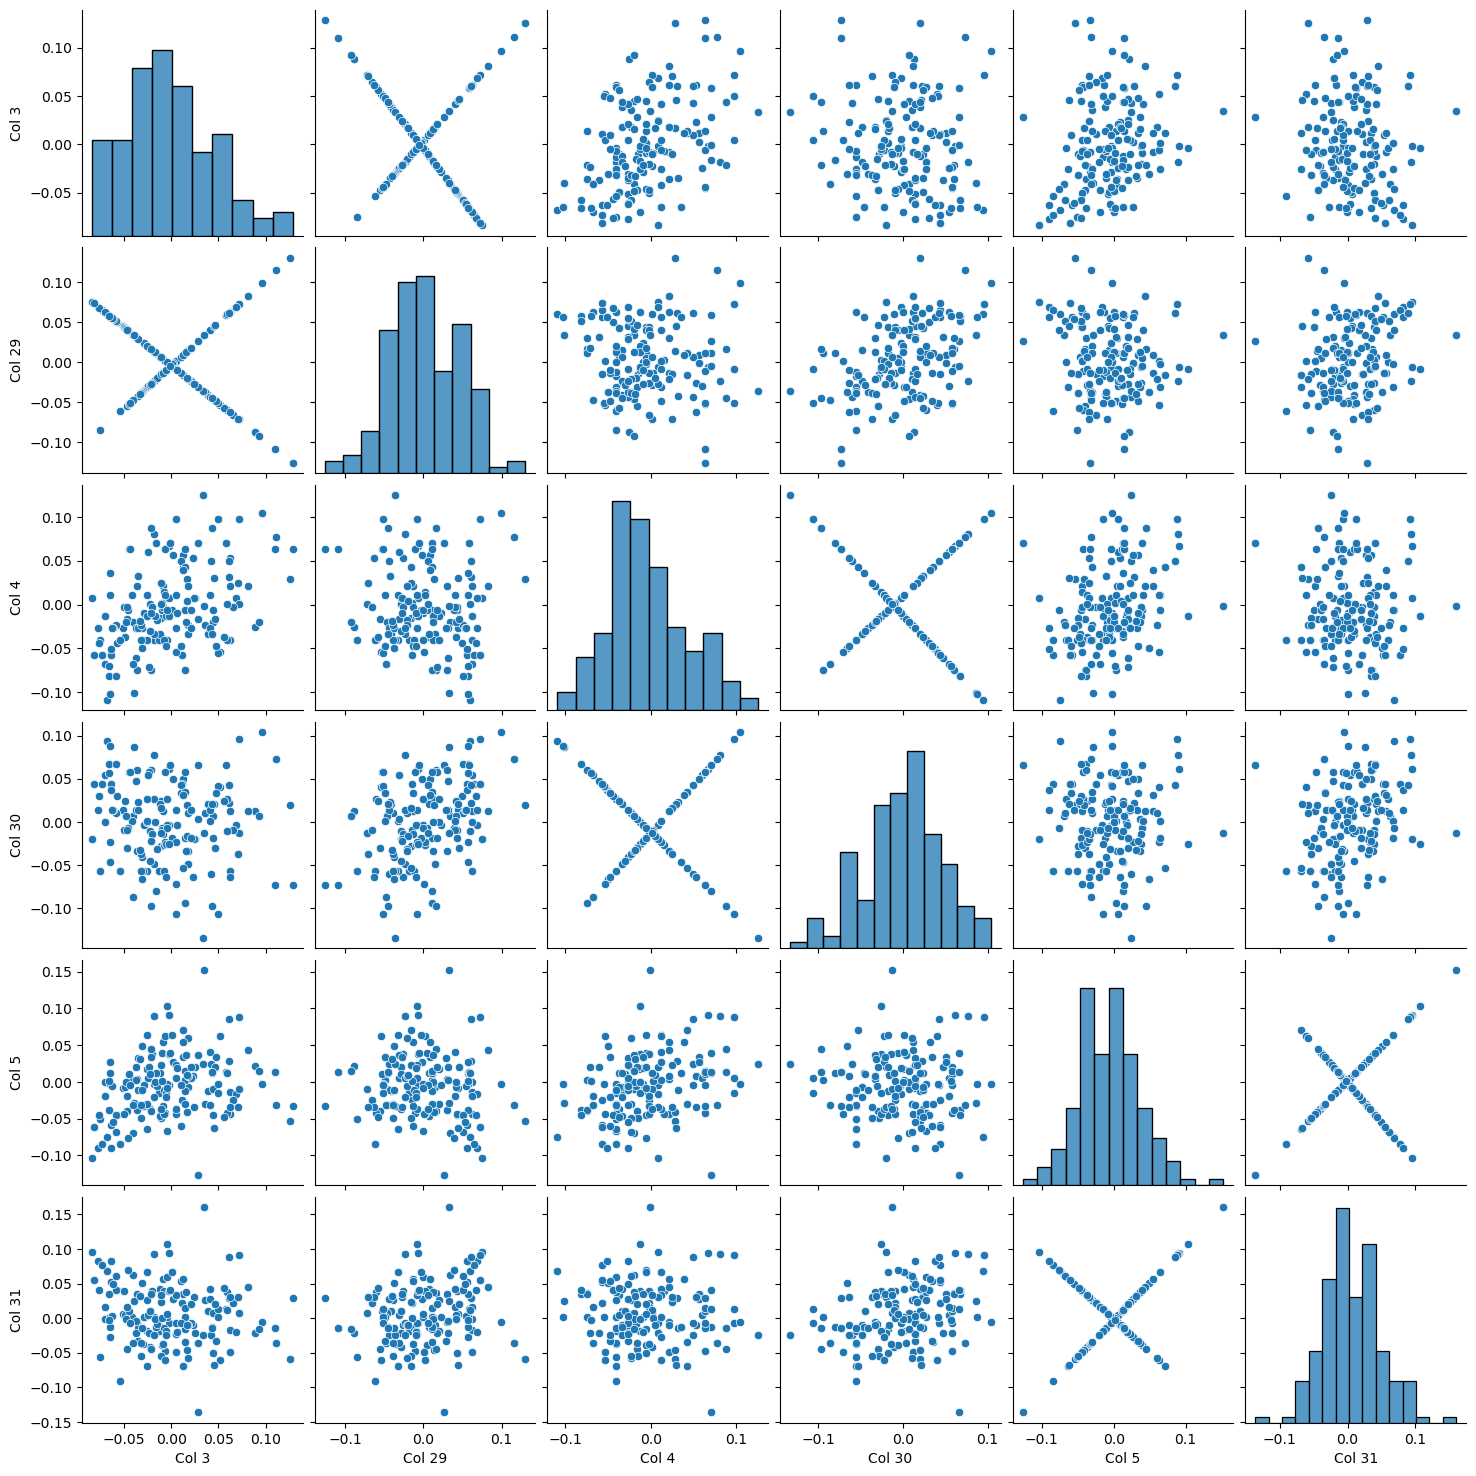

In [60]:
sns.pairplot(df[['Col 3', 'Col 29', 'Col 4', 'Col 30', 'Col 5', 'Col 31']])

We see that these transformations of previous variables begin at feature 11. We will remove all features after `Col 10` as they seem to be derived through transformations from features 1-10, therefore they are not independent.

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape

(128, 8)

We see that our data shape remains intact thanks to our MinMaxScaling.<br>It's equally important to look at the test data shape to make sure that our split captures the relationships between variables.

One limitation we might have with our model is the lack of data to train our model and evaluate it properly. You can see the outlines of the relationships between variables. Cross validation will be important so that we can use all our data to train and test.

## Models

### Linear Regression

We will implement a Lasso linear regression model to implement some regularization. We will scan for the proper alpha parameter by iterating over different magnitudes, 0.0001 - 10,000, and determining the best fit for the model.

In [68]:
from sklearn.linear_model import LassoCV, Lasso
np.logspace(-4, 4, 9)
# Create a LassoCV model
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 9), cv=5)

# Fit the model on the training data
lasso_cv.fit(X_train, y_train)

# Get the best alpha from cross-validation
best_alpha = lasso_cv.alpha_

# Train the final model with the best alpha on the entire training set
final_lasso = Lasso(alpha=best_alpha)
final_lasso.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# Display the best alpha
print(f'Best Alpha: {best_alpha}')

Mean Squared Error on Test Set: 2616.1158717458643
Best Alpha: 1.0


### Random Forest

We begin where we started which was training a Random Forest Regressor. Because we have a lot of features, this Random Forest Model should handle the complexity fairly well, the only thing to be aware of is overfitting.<br>We will account for overfitting of our Random Forest model by tuning the hyperparameters. Certain hyperparameters like `max_depth` should be kept low so that we're not creating overly complex trees. We will also be implementing bootstrapping into our model to increase the variability and as an effort to reduce overfitting.<br>The metrics by which we will judge our models by will be MSE (mean squared error), MAE (mean absolute error,) and R2 score. MSE and MAE tell us the error of our predictions as compared to the test set and are most similar to the Kaggle metrics for judging the fit of the model. We use R2 score so that we get a sense for the account of explainable variance our model gives us.<br>We will be using a Randomized Grid Search with cross validation to tune our hyperparameters and hopefully find a nice minimum on the loss. We are using Randomized search for speed and cross validation will make sure we use the entire dataset to train and test. We pick our hyperparameters by what makes the most sense, `n_estimators` should be kept lower to prevent overfitting, `max_depth` is also kept low for the same reason. `min_samples_split` is kept at a middle range to introduce a mild complexity and `min_samples_leaf` is also in the middle range for that reason.<br>To find the best model, we will run our search 20 times, plotting the MSE, MAE, and R2 score and storing the best model which minimizes MSE.

Running iterations: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


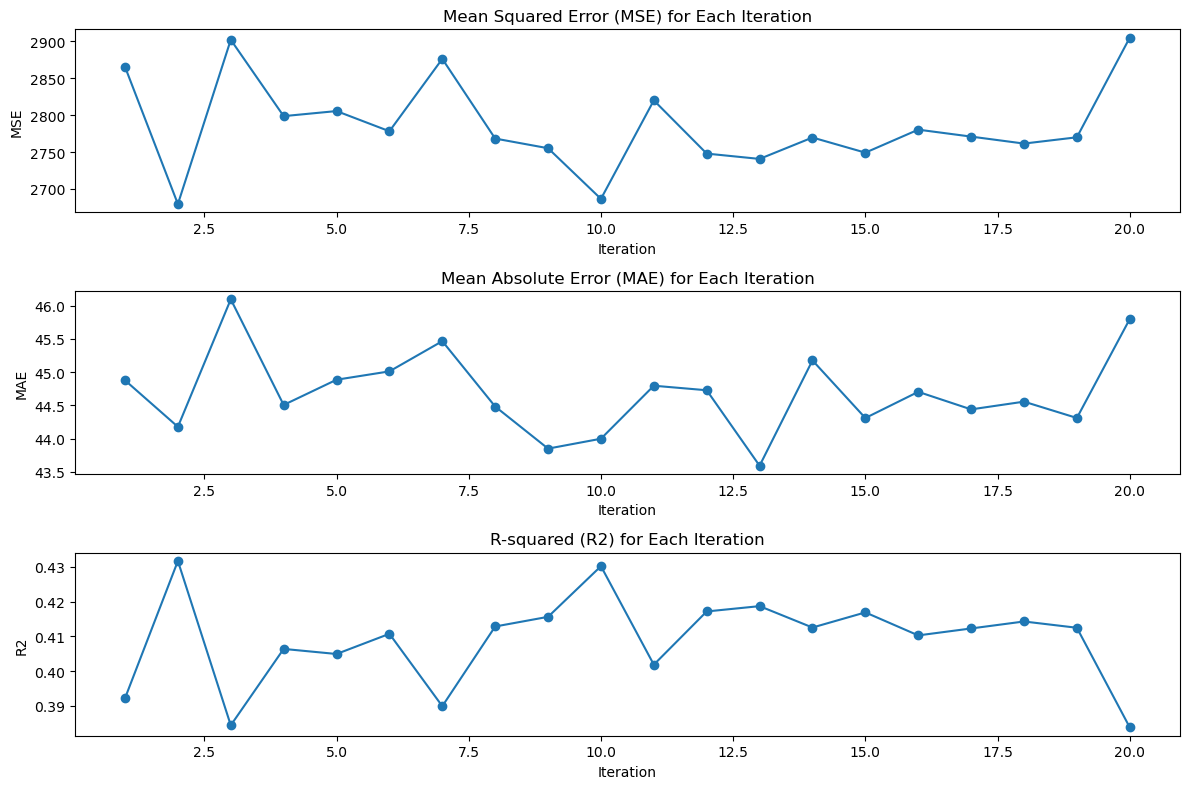

Best RF Model Parameters (based on MAE):
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 112, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [69]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm

# Number of iterations
num_iterations = 20

# Lists to store performance metrics for each iteration
mse_scores = []
mae_scores = []
r2_scores = []
best_models = []

for _ in tqdm(range(num_iterations), desc="Running iterations"): # This helps me by giving me a progress bar so I know how long loop will take
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': list(range(2, 6)),
        'min_samples_split': randint(2, 8),
        'min_samples_leaf': randint(3, 10)
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(),
        param_distributions=param_dist,
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    # Fit the random search on the preprocessed training data
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    best_models.append(best_model)

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store metrics for plotting
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Plotting
plt.figure(figsize=(12, 8))

# Plot MSE scores
plt.subplot(3, 1, 1)
plt.plot(range(1, num_iterations + 1), mse_scores, marker='o')
plt.title('Mean Squared Error (MSE) for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('MSE')

# Plot MAE scores
plt.subplot(3, 1, 2)
plt.plot(range(1, num_iterations + 1), mae_scores, marker='o')
plt.title('Mean Absolute Error (MAE) for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('MAE')

# Plot R2 scores
plt.subplot(3, 1, 3)
plt.plot(range(1, num_iterations + 1), r2_scores, marker='o')
plt.title('R-squared (R2) for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('R2')

plt.tight_layout()
plt.show()

# Find the best model based on MAE
best_mse_index = np.argmin(mse_scores)
best_mse_model = best_models[best_mse_index]
best_rf_params = best_mse_model.get_params()

# Print the parameters of the best MAE model
print("Best RF Model Parameters (based on MAE):")
print(best_rf_params)

After running for several minutes, we obtain plots of the MSE, MAE, and R2 scores for each model. We see that each metric are highly correlated with one another. The R2 score increases as MAE and MSE decreases.<br>Now we have a list of parameters for our best fit rf_model which are stored under `best_mae_params`. We will use this to fit our final rf_model.

In [70]:
rf_model = RandomForestRegressor(**best_rf_params)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, min_samples_leaf=3, n_estimators=112)

What if this random forest model is severly overfit? What we can do is actually pair this rf_model to another model of similar strength, perhaps one which can complement this model. We will fit an XGBoost model using the same method, iterative Randomized Search, to obtain a strong complimentary model to our rf_model. Finally, we can combine the power of both models and average out there predictions in a Voting Regressor model.

### XGBoost

We do the same process for finding the best fit model

Running iterations: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


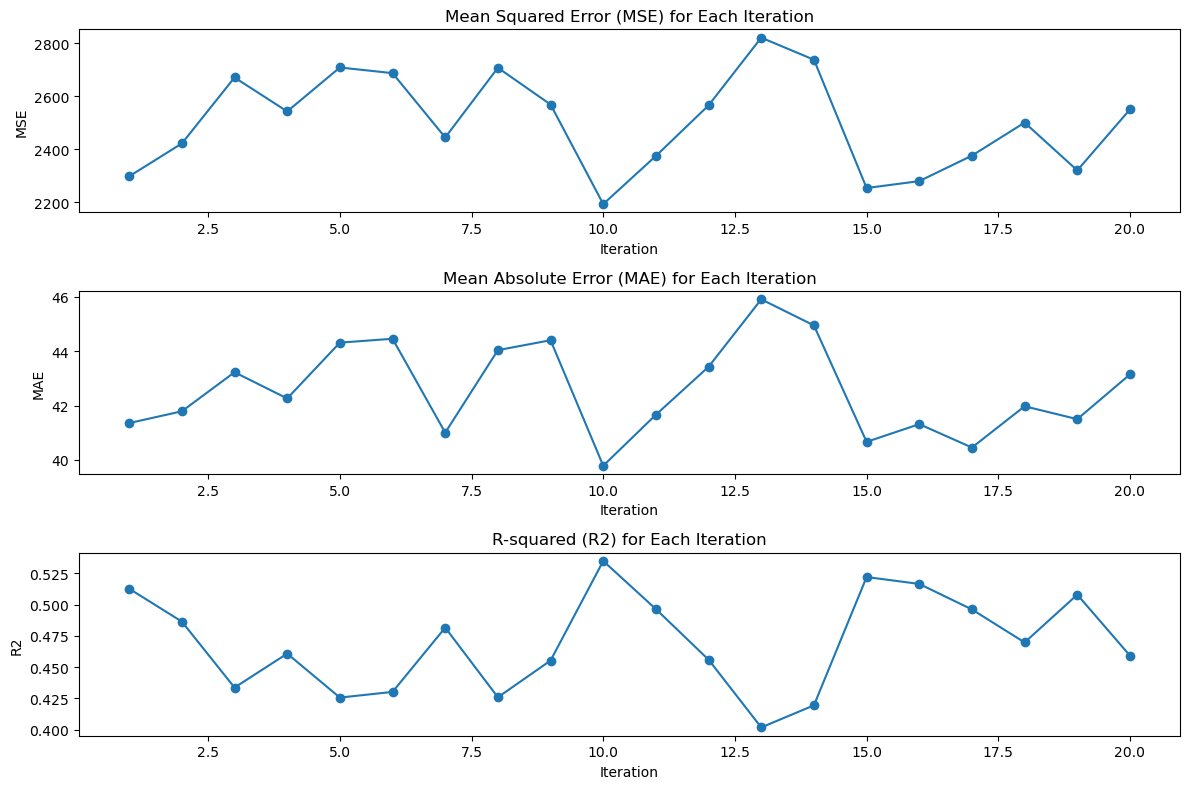

Best XGBoost Model Parameters (based on MAE):
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9478087936937701, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 2.7268880204702937, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1291130749703627, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 1, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 77, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.2684368260961123, 'reg_lambda': 4.326741686656742, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5436166142976191, 'tree_method': None, 'validate_parameters': 

In [71]:
from xgboost import XGBRegressor
from scipy.stats import uniform


# Number of iterations
num_iterations = 20

# Re-initialize lists for metrics and model
mse_scores = []
mae_scores = []
r2_scores = []
best_models = []

for _ in tqdm(range(num_iterations), desc="Running iterations"): # Create new parameter dictionary to traverse based on XGBoost hyperparameters
    param_dist = {
        'n_estimators': randint(50, 250),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(1, 10),
        'subsample': uniform(0.1, 0.9),
        'colsample_bytree': uniform(0.1, 0.9),
        'gamma': uniform(0, 10),
        'reg_alpha': uniform(0, 10),
        'reg_lambda': uniform(0.1, 10)
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=XGBRegressor(),
        param_distributions=param_dist,
        n_iter=100,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    # Fit the random search on the preprocessed training data
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    best_models.append(best_model)

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store metrics for plotting
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Plotting
plt.figure(figsize=(12, 8))

# Plot MSE scores
plt.subplot(3, 1, 1)
plt.plot(range(1, num_iterations + 1), mse_scores, marker='o')
plt.title('Mean Squared Error (MSE) for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('MSE')

# Plot MAE scores
plt.subplot(3, 1, 2)
plt.plot(range(1, num_iterations + 1), mae_scores, marker='o')
plt.title('Mean Absolute Error (MAE) for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('MAE')

# Plot R2 scores
plt.subplot(3, 1, 3)
plt.plot(range(1, num_iterations + 1), r2_scores, marker='o')
plt.title('R-squared (R2) for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('R2')

plt.tight_layout()
plt.show()

# Find the best model based on MAE
best_mse_index = np.argmin(mse_scores)
best_mse_model = best_models[best_mse_index]
best_xgb_params = best_mse_model.get_params()

# Print the parameters of the best MAE model
print("Best XGBoost Model Parameters (based on MAE):")
print(best_xgb_params)

The XGBoostRegressor runs much faster than our Random Forest so we arrive at a best fit model in less than a minute. We now fit our best XGBoost model and are ready to combine both models into our Voting Regressor.

In [72]:
xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9478087936937701, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.7268880204702937,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1291130749703627,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=77, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

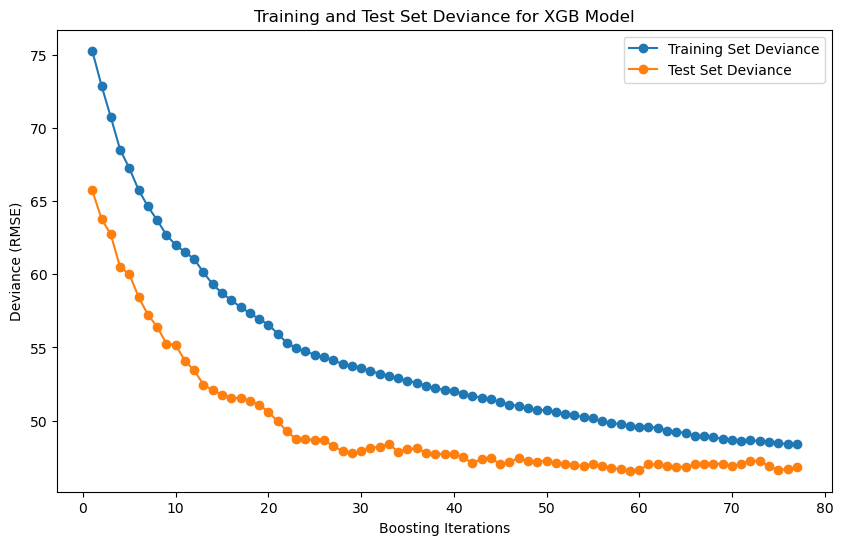

In [73]:
# Train the model and include eval set
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# Get the deviance values
train_deviance = xgb_model.evals_result()['validation_0']['rmse']
test_deviance = xgb_model.evals_result()['validation_1']['rmse']

# Plot the training and test set deviance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, best_xgb_params['n_estimators'] + 1), train_deviance, label='Training Set Deviance', marker='o')
plt.plot(np.arange(1, best_xgb_params['n_estimators'] + 1), test_deviance, label='Test Set Deviance', marker='o')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance (RMSE)')
plt.title('Training and Test Set Deviance for XGB Model')
plt.legend()
plt.show()

## Ensemble Model

Since we've already fit our Random Forest and XGBoost models we can go ahead and make predictions. We will evaluate each model separately and then the Voting regressor model as a whole.

In [74]:
from sklearn.ensemble import VotingRegressor

# # Create base models

y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_lasso = final_lasso.predict(X_test)

# Create an ensemble model (VotingRegressor)
model = VotingRegressor([('xgb', xgb_model), ('rf', rf_model), ('lasso', final_lasso)])

# Train the ensemble model
model.fit(X_train, y_train)

# Make predictions with the ensemble model
y_pred_ensemble = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for individual models and ensemble
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Print the evaluation metrics
print("XGBoost MSE:", mse_xgb)
print("XGBoost MAE:", mae_xgb)
print("XGboost R-squared:", r2_xgb)

print("RandomForestRegressor MSE:", mse_rf)
print("RandomForestRegressor MAE:", mae_rf)
print("RandomForestRegressor R-squared:", r2_rf)

print("Lasso MSE:", mse_lasso)
print("Lasso MAE:", mae_lasso)
print("Lasso R-squared:", r2_lasso)

print("Ensemble (VotingRegressor) MSE:", mse_ensemble)
print("Ensemble (VotingRegressor) MaE:", mae_ensemble)
print("Ensemble (VotingRegressor) R-squared:", r2_ensemble)

XGBoost MSE: 2192.5519203465083
XGBoost MAE: 39.78740215301514
XGboost R-squared: 0.5349265651963351
RandomForestRegressor MSE: 2614.2597110837014
RandomForestRegressor MAE: 43.62350266790658
RandomForestRegressor R-squared: 0.44547596249835364
Lasso MSE: 2616.1158717458643
Lasso MAE: 44.91281468065387
Lasso R-squared: 0.44508224273888586
Ensemble (VotingRegressor) MSE: 2339.611284175714
Ensemble (VotingRegressor) MaE: 41.38550467249436
Ensemble (VotingRegressor) R-squared: 0.5037330491744743


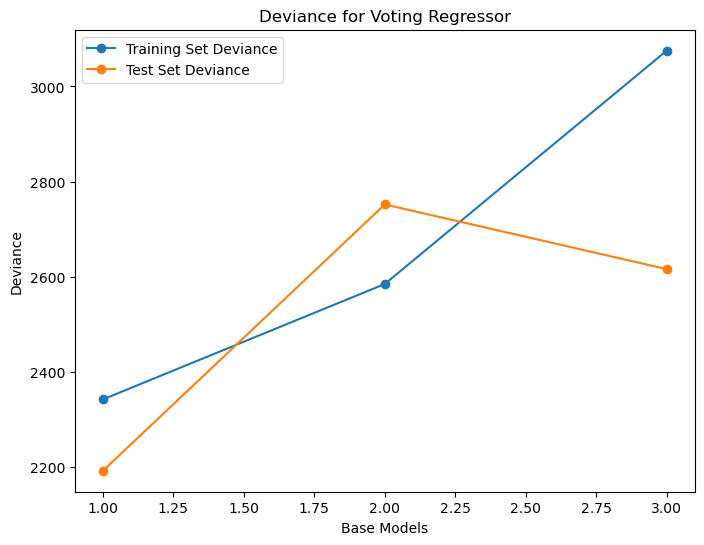

In [75]:
# Get the individual base models from the ensemble
base_models = model.estimators_

# Initialize arrays to store training and test set deviance
train_deviance = np.zeros((len(base_models),), dtype=np.float64)
test_deviance = np.zeros((len(base_models),), dtype=np.float64)

# Assuming you have X_test and y_test for your test set
for i, base_model in enumerate(base_models):
    # Get predictions for the training set
    train_pred = base_model.predict(X_train)
    # Get predictions for the test set
    test_pred = base_model.predict(X_test)
    
    # Calculate mean squared error for training and test set
    train_deviance[i] = mean_squared_error(y_train, train_pred)
    test_deviance[i] = mean_squared_error(y_test, test_pred)

# Plot the deviance
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(len(base_models)) + 1, train_deviance, label="Training Set Deviance", marker='o')
ax.plot(np.arange(len(base_models)) + 1, test_deviance, label="Test Set Deviance", marker='o')
ax.legend()
ax.set_xlabel("Base Models")
ax.set_ylabel("Deviance")
ax.set_title("Deviance for Voting Regressor")
plt.show()

As was expected, our models average out eachother's metrics and hopefully over/under-fitting.<br>We now move onto making predictions on the test set, but first we must scale our entire dataset.

In [77]:
# Now we fit the scaler on the entire X dataset which is now our training data

X_scaled = sc.transform(X)
X_scaled[0]

array([ 1.02073011,  1.37085007,  0.53883006, -0.95680361, -0.94924307,
        0.04520307,  0.54622424, -0.26790761])

In [78]:
# Fit final model on full data

model.fit(X_scaled, y)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9478087936937701,
                                          device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=2.7268880204702937,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=1,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=77,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('rf',
                             RandomForestRegressor(max_depth=2,
                                                   min_samples_leaf=3,
                                                   n_estimators=112)),
                            ('lasso', Lasso())])

## Submission

In [79]:
# Grab test data

X_test_kaggle = pd.read_csv('x_test.csv')
X_test_kaggle

,id,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,Col 9,...,Col 55,Col 56,Col 57,Col 58,Col 59,Col 60,Col 61,Col 62,Col 63,Col 64
0,160,-0.009147,-0.044642,-0.062252,-0.074528,-0.023584,-0.013214,0.004460,-0.039493,-0.035817,...,0.008349,-0.015256,-0.005439,-0.000883,0.028072,0.016765,0.009247,0.000324,0.017656,0.012271
1,161,-0.045472,0.050680,0.063852,0.070073,0.133274,0.131461,-0.039719,0.108111,0.075738,...,-0.103457,0.199861,0.203381,0.227999,-0.049270,-0.047594,-0.062812,0.132064,0.164034,0.108097
2,162,-0.052738,-0.044642,0.030440,-0.074528,-0.023584,-0.011335,-0.002903,-0.002592,-0.030751,...,0.010338,-0.022994,-0.008185,-0.013832,0.031522,0.022391,0.013997,-0.025637,-0.018503,-0.020176
3,163,0.016281,0.050680,0.072474,0.076958,-0.008449,0.005575,-0.006584,-0.002592,-0.023645,...,0.008831,-0.023683,-0.018763,-0.006797,0.031701,0.023892,0.004885,-0.025995,-0.021669,-0.049438
4,164,0.045341,-0.044642,-0.019140,0.021872,0.027326,-0.013527,0.100183,-0.039493,0.017763,...,-0.019722,-0.015062,-0.021151,-0.010178,-0.042931,0.060583,-0.016500,-0.040832,-0.008072,-0.025586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,237,0.056239,-0.044642,-0.068719,-0.068790,-0.000193,-0.001001,0.044958,-0.037648,-0.048362,...,0.008651,-0.022864,-0.014794,-0.014071,-0.000410,-0.028751,0.012837,0.008225,-0.017760,-0.019799
78,238,0.034443,0.050680,-0.009439,0.059744,-0.035968,-0.007577,-0.076536,0.071210,0.011008,...,0.022185,-0.031934,-0.017696,-0.010555,-0.070982,0.001339,0.051430,-0.011941,-0.049061,-0.025585
79,239,0.023546,-0.044642,0.019662,-0.012556,0.083740,0.038769,0.063367,-0.002592,0.066048,...,0.062830,-0.025035,0.040525,0.026320,0.028295,0.114936,0.083226,-0.030517,-0.021036,0.042812
80,240,0.048974,0.050680,0.074630,0.066630,-0.009825,-0.002253,-0.043401,0.034309,0.033657,...,0.011744,-0.024671,-0.017530,-0.015042,0.003414,-0.012630,-0.005237,-0.004729,-0.005315,-0.007738


We need to transform this test data through feature selection and scaling so that it contains only the features we trained our model on and with the same scaling.

In [80]:
# Feature selection
X_test_kaggle = X_test_kaggle[X.columns]
X_test_kaggle

,Col 1,Col 3,Col 4,Col 5,Col 7,Col 8,Col 9,Col 10
0,-0.009147,-0.062252,-0.074528,-0.023584,0.004460,-0.039493,-0.035817,-0.046641
1,-0.045472,0.063852,0.070073,0.133274,-0.039719,0.108111,0.075738,0.085907
2,-0.052738,0.030440,-0.074528,-0.023584,-0.002903,-0.002592,-0.030751,-0.001078
3,0.016281,0.072474,0.076958,-0.008449,-0.006584,-0.002592,-0.023645,0.061054
4,0.045341,-0.019140,0.021872,0.027326,0.100183,-0.039493,0.017763,-0.013504
...,...,...,...,...,...,...,...,...
77,0.056239,-0.068719,-0.068790,-0.000193,0.044958,-0.037648,-0.048362,-0.001078
78,0.034443,-0.009439,0.059744,-0.035968,-0.076536,0.071210,0.011008,-0.021788
79,0.023546,0.019662,-0.012556,0.083740,0.063367,-0.002592,0.066048,0.048628
80,0.048974,0.074630,0.066630,-0.009825,-0.043401,0.034309,0.033657,0.019633


In [81]:
# Scaling
X_test_kaggle = sc.transform(X_test_kaggle) # We transform our test data based on the scaling of our train data (X)
X_test_kaggle[0]

array([ 0.01451275, -1.29408825, -1.509067  , -0.46705076, -0.01238633,
       -0.69469377, -0.72771947, -0.83808629])

In [82]:
# Make predictions
y_pred_kaggle = model.predict(X_test_kaggle)
y_pred_kaggle

array([ 90.73476049, 257.63388797, 150.85723144, 201.19735863,
       145.05829973,  88.2213467 ,  90.82043363, 259.86788705,
       237.81036598, 200.26549602,  78.48807686,  91.99672558,
       249.93332629, 110.50575431, 168.53391587, 100.69531207,
       169.145712  , 212.53342493,  87.02915881, 130.58748179,
       164.48021944,  85.16668869, 147.69030015, 159.83901322,
       198.43715994, 196.26280365, 216.19785649,  87.41071502,
       127.37970117,  97.93928349, 176.16124913, 130.84899654,
        98.54220727, 158.05302073, 144.93332472, 171.67732716,
        91.73077966, 157.68342853, 145.6650973 , 185.9452582 ,
        82.95880245,  91.64063372, 177.77773996, 207.25582296,
       158.37686506, 225.71817321, 167.6934318 , 223.30442084,
       200.90543951, 131.04080646, 115.62146389, 157.99517918,
       126.8845164 ,  95.02643439,  94.63257387, 268.72273203,
       221.93087182, 211.25727351, 118.5385827 , 138.7136644 ,
        81.57468978, 127.31171318, 145.71866507, 120.12

In [83]:
kaggle_df = pd.read_csv('sample_submission.csv')
kaggle_df['y'] = y_pred_kaggle

# Export csv for submission
kaggle_df = kaggle_df[['id', 'y']]
kaggle_df.to_csv('Brian_____j10.csv', index=False)